# Viral Transmission Model

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import datetime

import scipy.optimize as spo
import scipy.integrate as spi

## Data Preprocessing

The dataset we will be using is the Global Coronavirus (COVID-19) Data (Corona Data Scraper) provided by Enigma. 

[AWS product link](https://aws.amazon.com/marketplace/pp/prodview-vtnf3vvvheqzw?qid=1597409751562&sr=0-1&ref_=brs_res_product_title#overview)
[Corona Data Scraper page](https://coronadatascraper.com/#home)


We are only interested in the state-level data in United States. To save time from opening a super large dataset, we save each state's data into small files.

In [2]:
df = pd.read_csv("datasets/timeseries.csv")
df_US = df[(df["country"]=="United States") & (df["level"]=="state")]
df_US = df_US[["state", "population", "cases", "deaths", "recovered", "tested", "hospitalized", "date"]]

/Users/xinyi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
states = np.unique(df_US["state"])
for state in states:
    df_US[df_US["state"]==state].to_csv("datasets/timeseries_states/"+state+".csv", index=0)

## State Data Snapshot

In [4]:
def chooseState(state, output=True):
    df_state = pd.read_csv("datasets/timeseries_states/"+state+".csv")
    
    ### data cleaning
    
    # some col is missing in some state's report
    na_cols = []
    for col in df_state.columns.values:
        if df_state[col].isna().all():
            na_cols.append(col)
    for col in na_cols:
        df_state = df_state.drop(col, axis=1)

    # some data is missing at the beginning of the outbreak
    suggest_startdate = df_state.iloc[0]["date"]
    for i in range(len(df_state.index)):
        if df_state.iloc[i].notna().all():
            suggest_startdate = df_state.iloc[i]["date"]
            break
    
    # regulate the data
    df_state = df_state.fillna(0)
    df_state["date"] = pd.to_datetime(df_state["date"])
    

    if output:
        ### snapshot and mark data inconsistency
        plt.figure()
        plt.title(state)
        for line, style in [ ("cases", "-b"), ("deaths", "-k"), ("recovered", "-g")]:
            if line in df_state.columns.values:
                plt.plot(df_state[line], style, label=line)
                for i in range(1, len(df_state.index)):
                    if abs(df_state[line][i] - df_state[line][i-1]) > (max(df_state[line]) - min(df_state[line])) / 6:
                        plt.plot(i, df_state[line][i], "xr")
        plt.legend()
    
        ### print out data-cleaning message
        if na_cols == []:
            print("Data complete, ready to analyze.")
        else:
            print("Data incomplete, cannot analyze.")
            print("NA cols: ", na_cols)
        print("Suggest choosing start date after", suggest_startdate)
        
    ### discard the outliers
    for line in [ "cases", "deaths", "recovered", "hospitalized"]:
        if line in df_state.columns.values:
            col_idx = list(df_state.columns).index(line)
            for i in range(1, len(df_state.index)-1):
                if (df_state.iloc[i, col_idx] - df_state.iloc[i-1, col_idx]) * (df_state.iloc[i+1, col_idx] - df_state.iloc[i, col_idx]) < -((max(df_state[line]) - min(df_state[line])) /4)**2:
                    df_state.iloc[i, col_idx] = (df_state.iloc[i-1, col_idx] + df_state.iloc[i+1, col_idx]) / 2
                    if output:
                        plt.plot(i, df_state[line][i], "or")
    
    return df_state, na_cols, suggest_startdate

For example, we are interested in New York state.

Data complete, ready to analyze.
Suggest choosing start date after 2020-03-27


,state,population,cases,deaths,recovered,tested,hospitalized,date
43,New York,19453561,76.0,0.0,0.0,404.0,0.0,2020-03-07
50,New York,19453561,524.0,5.0,0.0,3303.0,0.0,2020-03-14
64,New York,19453561,52318.0,728.0,2726.0,155934.0,10454.0,2020-03-28
67,New York,19453561,75795.0,1550.0,4975.0,205186.0,17085.0,2020-03-31
202,New York,19453561,423440.0,25228.0,73907.0,6816381.0,89995.0,2020-08-13


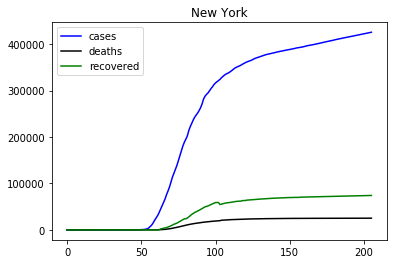

In [5]:
state = "New York"
df_state, _, _ = chooseState(state)
df_state.sample(5).sort_values("date")

For example, we are interested in the first two weeks in April.

In [6]:
def chooseTime(df_state, start_date, end_date):
    start = np.datetime64(start_date)
    end = np.datetime64(end_date)
    
    # The time period of interest 
    sample = df_state[ (df_state["date"] >= start) & (df_state["date"] <= end) ]
    # The future period to determine "exposed"
    sample_future = df_state[ (df_state["date"] >= start + np.timedelta64(14,'D')) & (df_state["date"] <= end + np.timedelta64(14,'D')) ]

    return sample, sample_future

In [7]:
start_date, end_date = "2020-04-01", "2020-04-14"
sample, sample_future = chooseTime(df_state, start_date, end_date)

## SEIR Infection Model

![title](model.png)

We can use an SEIR model to describe the transmission dynamics of Covid19 as above.

We Assume...

- Susceptible (S): healthy people, will be infected and turn into E after close contact with E or Q.
- Exposed (E): infected but have no symptoms yet, infectious with a rate of $\lambda$. E will turn into I after the virus incubation period, which is 14 days on average. So we assume $\sigma = 1/14$, dE/dt (t) = dI/dt (t+14).
- Infectious (I): infected and have symptoms. We will take the data of test_positive or cases_reported as the data of I. The severe cases will be hospitalized (H), the mild cases will be in self quarantine (Q). I may recover or die after some time.
    - Self Quarantine (Q): have symptoms, may still have some contact with others, thus infectious with a different rate of $c\lambda$ ($0 \le c \le 1$). We also assume $Q = kI$, where $k = 1 - avg(\frac{\Delta hospitalized}{\Delta test\_pos}) $
    - Hospitalized (H): have symptoms, kept in hospitals, assume no contact with S. 
- Recovered (R): recovered and immune, may turn into S again (immunity lost or virus not cleared)
- Dead (X): dead unfortunately :(



Therefore, we have a set of differential equations to describe this process:

$\begin{aligned}
&\frac{dS}{dt}&
&=& - \lambda \frac{S}{N} E - c\lambda \frac{S}{N} Q + \alpha R ~~~
&=& - \lambda \frac{S}{N} E - c\lambda \frac{S}{N} kI + \alpha R
\\
&\frac{dE}{dt}&
&=&   \lambda \frac{S}{N} E + c\lambda \frac{S}{N} Q - \sigma E ~~~
&=&   \lambda \frac{S}{N} E + c\lambda \frac{S}{N} kI - \sigma E
\\
&\frac{dI}{dt}&
&=& \sigma E - \mu I - \omega I 
\\
&\frac{dX}{dt}&
&=& \omega I 
\\
&\frac{dR}{dt}&
&=& \mu I - \alpha R 
\end{aligned}$

$S + E + I + R + X = N,~ I = Q + H$


Apply to our datasets, we have:

$ R = recovered,~ X = deaths,~ I = test\_pos - deaths - recovered,\\
E(t) = I(t+14) - I(t),~ S = N - E - I - R - X,\\
k = 1 - avg(\frac{\Delta hospitalized}{\Delta test\_pos})
$

In [8]:
### run SEIR model on sample data

def SEIR(sample, sample_future, output=True):
    
    ### differential equations for spi.odeint, INP - initial point, t - time range
    # dS/dt = - lamda*S/N*E - c*lamda*S/N*k*I + alpha*R
    # dE/dt =   lamda*S/N*E + c*lamda*S/N*k*I - sigma*E
    # dI/dt = sigma*E - miu*I - omega*I
    # dX/dt = omega*I
    # dR/dt = miu*I - alpha*R
    def diff_eqs(INP, t, lamda_p, c_p, alpha_p, omega_p, miu_p):
        Y = np.zeros((5))
        V = INP
        Y[0] = - lamda_p*V[0]/N*V[1] - c_p*lamda_p*V[0]/N*k*V[2] + alpha_p*V[4]
        Y[1] =   lamda_p*V[0]/N*V[1] + c_p*lamda_p*V[0]/N*k*V[2] - sigma*V[1]
        Y[2] = sigma*V[1] - miu_p*V[2] - omega_p*V[2]
        Y[3] = omega_p*V[2]
        Y[4] = miu_p*V[2] - alpha_p*V[4]
        return Y

    ### cost function for optimization
    def MSE(params):
        INP = (S[0], E[0], I[0], X[0], R[0])
        t_range = np.arange(0, len(S), 1)
        RES = spi.odeint(diff_eqs, INP, t_range, args=tuple(params))
        mse = 0
        for i in range(len(S)):
            mse += ( (RES[i,0] - S[i]) ) **2
            mse += ( (RES[i,1] - E[i]) ) **2
            mse += ( (RES[i,2] - I[i]) ) **2
            mse += ( (RES[i,3] - X[i]) ) **2
            mse += ( (RES[i,4] - R[i]) ) **2
        mse = mse / len(S)
        return mse
    
    
    ### get necessary data from dataset

    cases = np.array(list(sample["cases"])) # test_positive
    cases_future = np.array(list(sample_future["cases"])) # to calculate exposed
    hospitalized = np.array(list(sample["hospitalized"])) # to calculate k
    deaths = np.array(list(sample["deaths"])) # X
    recovered = np.array(list(sample["recovered"])) # R
    N = np.mean(df_state["population"])
    
    X = deaths
    R = recovered
    I = cases - deaths - recovered
    E = cases_future - cases
    S = N - E - I - X - R

    dS = S[1:] - S[:-1]
    dE = E[1:] - E[:-1]
    dI = I[1:] - I[:-1]
    dX = X[1:] - X[:-1]
    dR = R[1:] - R[:-1]
    S = S[:-1]
    E = E[:-1]
    I = I[:-1]
    X = X[:-1]
    R = R[:-1]
    
    
    ### guess params
    # By experience: k, sigma
    k = 1 - np.mean( (hospitalized[1:]-hospitalized[0:-1] +1e-5) / (cases[1:]-cases[:-1] +1e-5) ) # k = deltaH / deltaCases
    sigma = 1/14 # virus incubation period = 14 days
    # From optimization: lamda, c, alpha, omega, miu
    alpha0 = 0.006
    omega0 = np.mean((dX+1e-5) / (I+1e-5)) # dx/dt = omega*i
    c0 = 0.4
    lamda0 = np.mean(- (dS - alpha0*R +1e-5) / (S/N * (E+c0*k*I) +1e-5) ) # dS/dt = - lamda*S/N*(E+ckI) + alpha*R
    miu0 = np.mean((dR + alpha0*R +1e-5) / (I+1e-5)) # dr/dt = miu*i - alpha*r
    
    ### Optimization to find best params
    params0 = (lamda0, c0, alpha0, omega0, miu0) # lamda, c, alpha, omega, miu
    ret = spo.minimize(MSE, params0, bounds=[(0,1), (0,1), (0,1), (0,1), (0,1)])
    params = ret.x
    params0 = [round(i,8) for i in params0]
    params = [round(i,8) for i in params]
    k = round(k,8)
    sigma = round(sigma,8)
    
    if output:
        print("Estimated k: ", k, "; sigma: ", sigma)
        print("Optimization for lamda, c, alpha, omega, miu")
        print("params0: ", params0)
        print("params: ", params)
    
        ### solve ode and plot
        INP = (S[0], E[0], I[0], X[0], R[0])
        t_range = np.arange(0, len(S)*5, 1)
        RES = spi.odeint(diff_eqs, INP, t_range, args=tuple(params))

        plt.figure(figsize=(10,6))
        
        plt.plot(RES[:,1], '-b', label='E_predict')
        plt.plot(RES[:,2], '-r', label='I_predict')
        plt.plot(RES[:,3], '-k', label='X_predict')
        plt.plot(RES[:,4], '-g', label='R_predict' )
        plt.plot(E, "xb", label="E_real")
        plt.plot(I, "xr", label="I_real")
        plt.plot(X, "xk", label="X_real")
        plt.plot(R, "xg", label="R_real")

        plt.grid()
        plt.xlabel('Time', fontsize = 12)
        plt.ylabel('number of people', fontsize = 12)
        plt.legend(loc=0)
        plt.title(state + ": " + str(start_date) + " - " + str(end_date), fontsize = 14)
        plt.show();
    
    return params, k, sigma

Estimated k:  0.70637671 ; sigma:  0.07142857
Optimization for lamda, c, alpha, omega, miu
params0:  [0.0438031, 0.4, 0.006, 0.0058387, 0.01392389]
params:  [0.05296159, 0.0, 0.0, 0.00293508, 0.01087961]


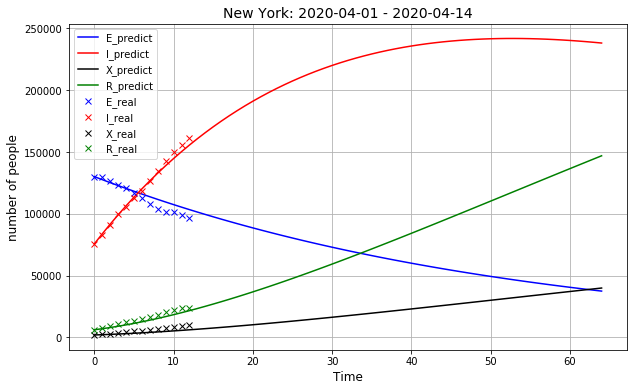

In [9]:
params = SEIR(sample, sample_future)

### Example1: California

Data complete, ready to analyze.
Suggest choosing start date after 2020-03-27


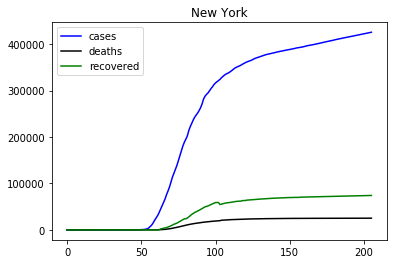

In [26]:
state = "New York"
df_state, _, _ = chooseState(state)
# df_state.sample(5).sort_values("date")

Everything seems fine (except that jump), then we choose an appropriate time period to analyze

Estimated k:  0.7614624 ; sigma:  0.07142857
Optimization for lamda, c, alpha, omega, miu
params0:  [0.02543615, 0.4, 0.006, 0.00239126, 0.01059777]
params:  [0.04005496, 0.0, 0.0, 0.00041208, 0.00822793]


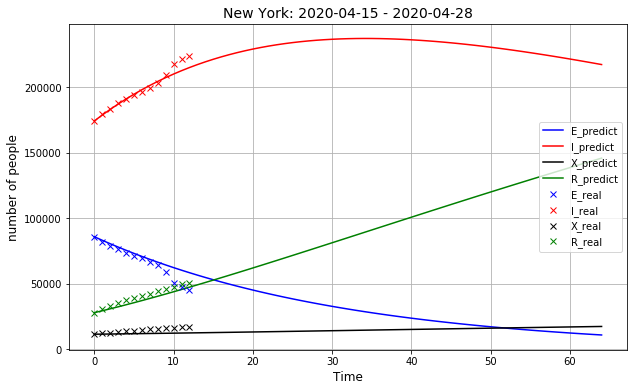

In [27]:
start_date, end_date = "2020-04-15", "2020-04-28"
sample, sample_future = chooseTime(df_state, start_date, end_date)
params = SEIR(sample, sample_future)

### Example2: New York

Data complete, ready to analyze.
Suggest choosing start date after 2020-03-27


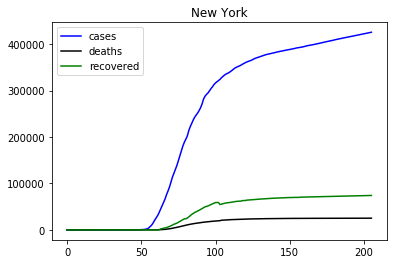

In [12]:
state = "New York"
df_state, _, _ = chooseState(state)
# df_state.sample(5).sort_values("date")

Everything seems fine, then we choose an appropriate time period to analyze.

Estimated k:  0.78615074 ; sigma:  0.07142857
Optimization for lamda, c, alpha, omega, miu
params0:  [0.01844098, 0.4, 0.006, 0.00110717, 0.00247924]
params:  [0.04535111, 0.0, 0.0, 0.00049004, 3.011e-05]


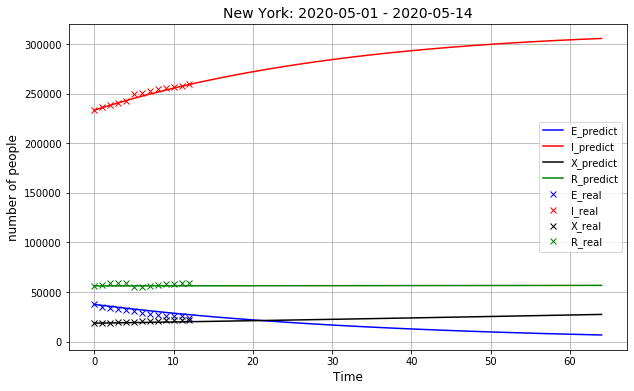

In [13]:
start_date, end_date = "2020-05-01", "2020-05-14"
sample, sample_future = chooseTime(df_state, start_date, end_date)
params = SEIR(sample, sample_future)

### Example3: Illinois

Data incomplete, cannot analyze.
NA cols:  ['recovered', 'hospitalized']
Suggest choosing start date after 2020-03-17


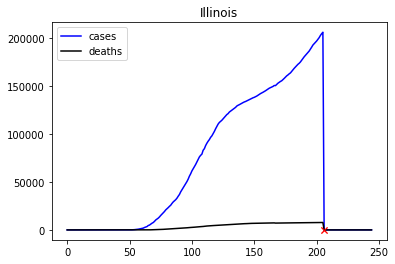

In [14]:
state = "Illinois"
df_state, _, _ = chooseState(state)
# df_state.sample(5).sort_values("date")

There are too many missing data (no recovered) for Illinois, we can not analyze now. 

### Example4: Texas

Data incomplete, cannot analyze.
NA cols:  ['hospitalized']
Suggest choosing start date after 2020-03-30


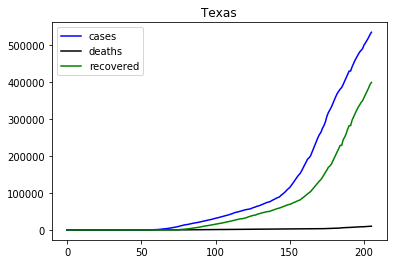

In [15]:
state = "Texas"
df_state, _, _ = chooseState(state)
# df_state.sample(5).sort_values("date")

The hospitalized data is missing, we may use the average k instead. But we can not analyze now. 

### Generate state-time-params data

Now that our SEIR infection model is working, we choose some states of interest and compute the corresponding optimal parameters for further modeling.

In [16]:
StateOfInterest = ["Arizona", "California", "Minnesota", "New Mexico", "New York", 
                   "Oklahoma", "South Carolina", "Tennessee", "Utah", "Virginia", 
                   "West Virginia", "Wisconsin"]

df_SOI = pd.DataFrame(columns = ["state", "startdate", "enddate", "k", "sigma", "lamda", "c", "alpha", "omega", "miu"])

for state in StateOfInterest:
    df_state, _, suggest_startdate = chooseState(state, False)
    
    # choose 15 days as a period
    if np.datetime64(suggest_startdate,'D') - np.datetime64(suggest_startdate,'M') <= np.timedelta64(14,'D'):
        real_startdate = np.datetime64(suggest_startdate,'M') + np.timedelta64(15,'D')
    else:
        real_startdate = np.datetime64(np.datetime64(suggest_startdate,'M') + np.timedelta64(1,'M'), 'D')

    stopdate = np.datetime64("2020-07-01")
    startdate = real_startdate

    while True:
        if startdate > stopdate:
            break
        enddate = startdate + np.timedelta64(14,'D')
        
        sample, sample_future = chooseTime(df_state, startdate, enddate)
        params = SEIR(sample, sample_future, False)
        
        df_SOI = df_SOI.append([{"state":state, "startdate":startdate, "enddate":enddate, "k":params[1], "sigma":params[2], "lamda":params[0][0], "c":params[0][1], "alpha":params[0][2], "omega":params[0][3], "miu":params[0][4]}], ignore_index=True)
        
        if np.datetime64(startdate,'D') - np.datetime64(startdate,'M') <= np.timedelta64(0,'D'):
            startdate = np.datetime64(startdate,'M') + np.timedelta64(15,'D')
        else:
            startdate = np.datetime64(np.datetime64(startdate,'M') + np.timedelta64(1,'M'), 'D')
        

In [17]:
df_SOI.to_csv("datasets/model_out.csv", index=0)
df_SOI.sample(5)

,state,startdate,enddate,k,sigma,lamda,c,alpha,omega,miu
5,Arizona,2020-07-01,2020-07-15,0.973235,0.071429,0.060925,0.000000,0.000000,0.000000,0.003805
51,Utah,2020-05-01,2020-05-15,0.915468,0.071429,0.074351,0.000000,0.000000,0.000673,0.036875
12,Minnesota,2020-04-01,2020-04-15,0.728123,0.071429,0.163018,0.000000,0.188637,0.004155,0.168496
45,Tennessee,2020-05-01,2020-05-15,0.909080,0.071429,0.031219,1.000000,0.000000,0.000000,0.034320
23,New Mexico,2020-06-16,2020-06-30,0.839211,0.071429,0.072116,0.272178,0.010281,0.000799,0.025089
